In [1]:
#Bibliotecas
import json
import gzip
import pandas as pd
#import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import torch
import torch.nn.functional as F
import copy

from transformers import BertTokenizer, BertForMaskedLM

from tqdm import tqdm

from collections import defaultdict
from collections import Counter

from matplotlib import rc

from urllib.request import urlopen

from textwrap import wrap

from torch import nn, optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Cargar los datos

data = []
with gzip.open('Digital_Music.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

#Normalizar las columnas para separar style.Format:
data2 = pd.json_normalize(data)

#Convertir la lista a un dataframe de pandas
df = pd.DataFrame.from_dict(data2)

#Cantidad de datos en el dataframe
print(len(df))

1584082


In [3]:
###TRANSFORMACIONES
#Se eliminan las columnas que no se utilizaran
df = df.drop(['asin', 'unixReviewTime', 'image', 'reviewerName', 'style.Color:', 'style.Size:'], axis=1)

#Cambiar el formato del reviewTime para transformarla a datetime
df['reviewTime'] = df['reviewTime'].str.replace(' ', ',')
df['reviewTime'] = df['reviewTime'].str.replace(',,', ',')
df['reviewTime'] = df['reviewTime'].str.replace(',', '-')
df['reviewTime'] = pd.to_datetime(df['reviewTime'], infer_datetime_format=True)

In [4]:
#Se eliminan las filas de datos que correspondan a un estilo de formato distinto a Vinyl, Audio CD y MP3 Music.
indexNames = df[ (df['style.Format:'] != ' Vinyl')
                & (df['style.Format:'] != ' Audio CD')
                & (df['style.Format:'] != ' MP3 Music') ].index
df.drop(indexNames , inplace=True)

In [5]:
#Llenar los NaN de la columna 'vote' con 0 para hacer el análisis
df['vote'] = df['vote'].str.replace(',', '').astype(float)
df['vote'] = df['vote'].fillna(0)
df['vote'] = df['vote'].dropna()
df['vote'] = df['vote'].astype(int)
df['vote'].isna().sum()

0

In [6]:
#Se crea una columna con el conteo de caracteres
df["review_length"]= df["reviewText"].str.len()

#Eliminacion de datos nulos en el dataframe
df = df.dropna()

#Asignar tipos de datos correcto a cada columna
df['review_length'] = df['review_length'].astype(int)
df['overall'] = df['overall'].astype(int)

#Cantidad de datos en el dataframe
print(len(df))

1306426


In [ ]:
#Verificacion de tipos de datos
df.dtypes

In [ ]:
#Revisar cantidad de nulos
df.isna().sum()

C:\Users\gabal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


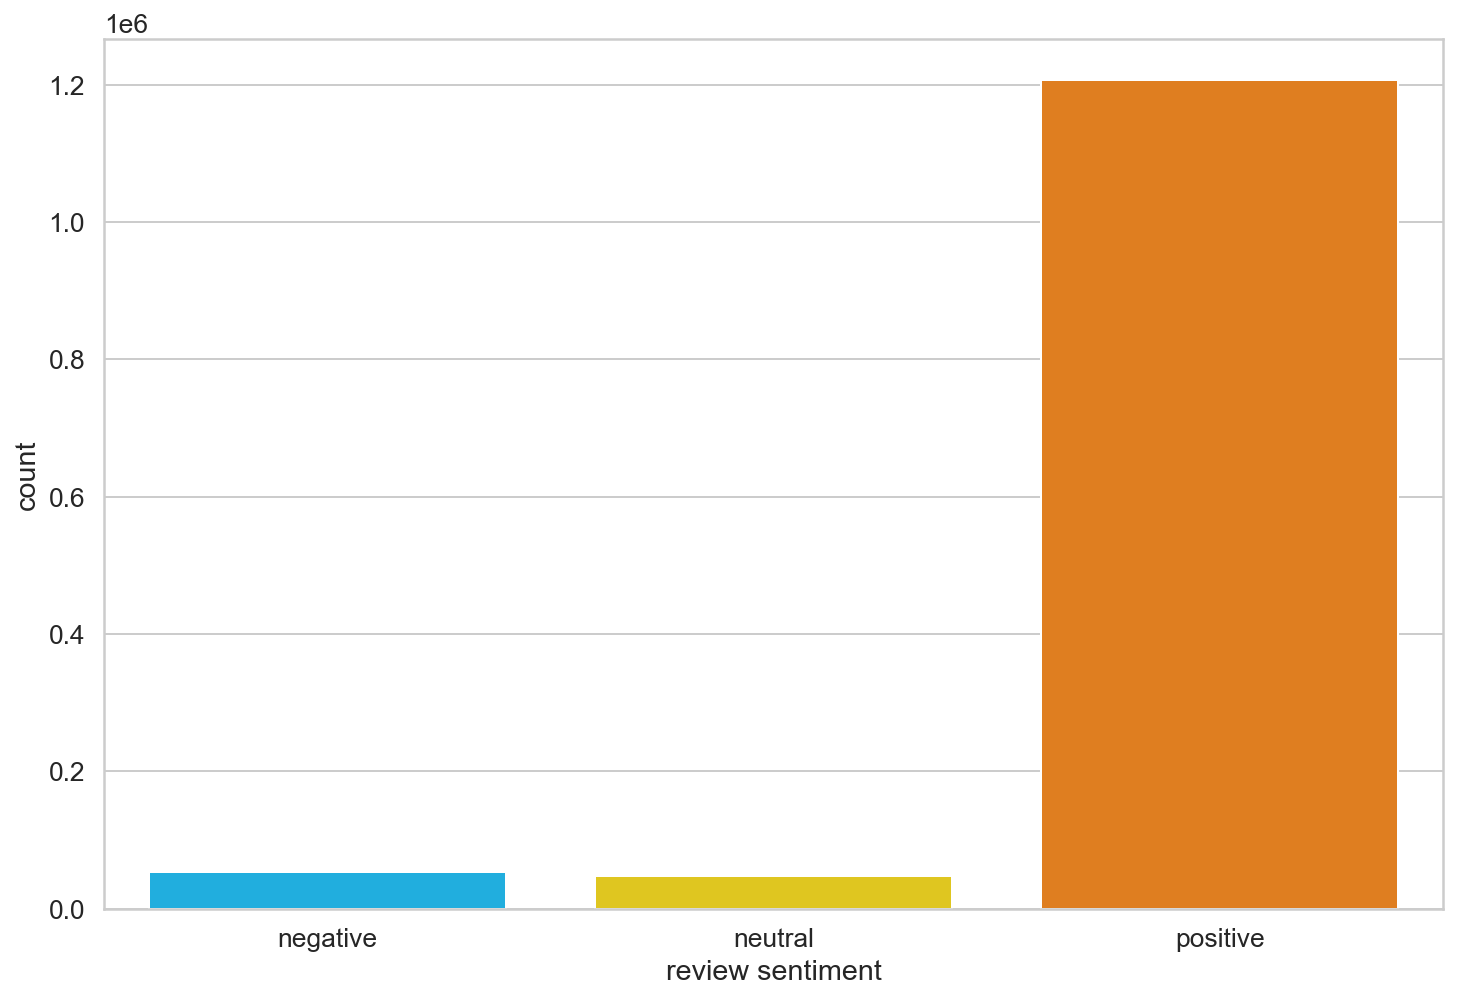

In [8]:
###BERT
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.overall.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [9]:
df

,overall,verified,reviewTime,reviewerID,reviewText,summary,style.Format:,vote,review_length,sentiment
0,5,True,2013-12-22,A1ZCPG3D3HGRSS,This is a great cd full of worship favorites!!...,Great worship cd,Audio CD,0,104,2
1,5,True,2013-09-11,AC2PL52NKPL29,"So creative! Love his music - the words, the ...",Gotta listen to this!,Audio CD,0,127,2
2,5,True,2013-03-02,A1SUZXBDZSDQ3A,"Keith Green, gone far to early in his carreer,...",Great approach still gets the message out,Audio CD,0,309,2
3,5,True,2012-12-02,A3A0W7FZXM0IZW,Keith Green had his special comedy style of Ch...,Great A must have,Audio CD,0,159,2
4,5,False,2012-01-07,A12R54MKO17TW0,Keith Green / So you wanna go back to Egypt......,A great one from Keith with a guest appearance...,Audio CD,6,208,2
...,...,...,...,...,...,...,...,...,...,...
1584077,5,True,2018-03-03,AR3KABMPL5L0O,Casting Crowns....you do it so well! Awesome s...,Awesome song!,MP3 Music,0,50,2
1584078,4,True,2018-01-24,A2N53GHW73INDH,This band has produced many inspiring Christia...,This song in particular speaks about what it's...,MP3 Music,0,199,2
1584079,5,True,2017-04-21,ABNKLDCCVJKW1,Awesome band and awesome song. This is my next...,Five Stars,MP3 Music,0,70,2
1584080,5,True,2018-02-23,AMWSDABZWFRAT,Excellent,Five Stars,MP3 Music,0,9,2


In [10]:
#TRANSFORMACIÓN DE VARIABLES NOMINALES A NUMÉRICAS

df_numeric = df[['overall', 'vote', 'sentiment', 'review_length']]
df_categorical = df[['verified', 'style.Format:']]

In [11]:
#Verificar cuales son los valores únicos para codificar
print(df['verified'].unique())
print(df['style.Format:'].unique())

[ True False]
[' Audio CD' ' MP3 Music' ' Vinyl']


In [12]:
#Codificar verified
verified_encoder = LabelEncoder()
verified_encoder.fit(df_categorical['verified'])
verified_values = verified_encoder.transform(df_categorical['verified'])

In [13]:
#Codificar style.Format: 
format_encoder = OneHotEncoder()
format_reshaped = np.array(df_categorical['style.Format:']).reshape(-1, 1)
format_values = format_encoder.fit_transform(format_reshaped)

In [14]:
verified = pd.DataFrame(verified_values, columns=['verified'])
format = pd.DataFrame(format_values.toarray(), columns=[' Audio CD', ' MP3 Music', ' Vinyl'])
df_categorical_encoded = pd.concat([verified, format], axis=1)

In [15]:
df_categorical_encoded.index = range(df_categorical_encoded.shape[0])
df_numeric.index = range(df_numeric.shape[0])

In [16]:
df_new = pd.concat([df_numeric, df_categorical_encoded], axis=1)

In [17]:
df_new

,overall,vote,sentiment,review_length,verified,Audio CD,MP3 Music,Vinyl
0,5,0,2,104,1,1.0,0.0,0.0
1,5,0,2,127,1,1.0,0.0,0.0
2,5,0,2,309,1,1.0,0.0,0.0
3,5,0,2,159,1,1.0,0.0,0.0
4,5,6,2,208,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1306421,5,0,2,50,1,0.0,1.0,0.0
1306422,4,0,2,199,1,0.0,1.0,0.0
1306423,5,0,2,70,1,0.0,1.0,0.0
1306424,5,0,2,9,1,0.0,1.0,0.0


In [18]:
#Revisar cantidad de nulos
df_new.isna().sum()

overall          0
vote             0
sentiment        0
review_length    0
verified         0
 Audio CD        0
 MP3 Music       0
 Vinyl           0
dtype: int64

In [19]:
LABELS= ['Normal','Fraudulent']

In [20]:
#definimos nuestras etiquetas y features
y = df_new['sentiment']
X = df_new.drop('sentiment', axis=1)
#dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
 
#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

#definimos funcion para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [21]:
df_new.index

RangeIndex(start=0, stop=1306426, step=1)

Distribution before resampling Counter({2: 1206646, 0: 53014, 1: 46766})
Distribution after resampling Counter({0: 46766, 1: 46766, 2: 46766})


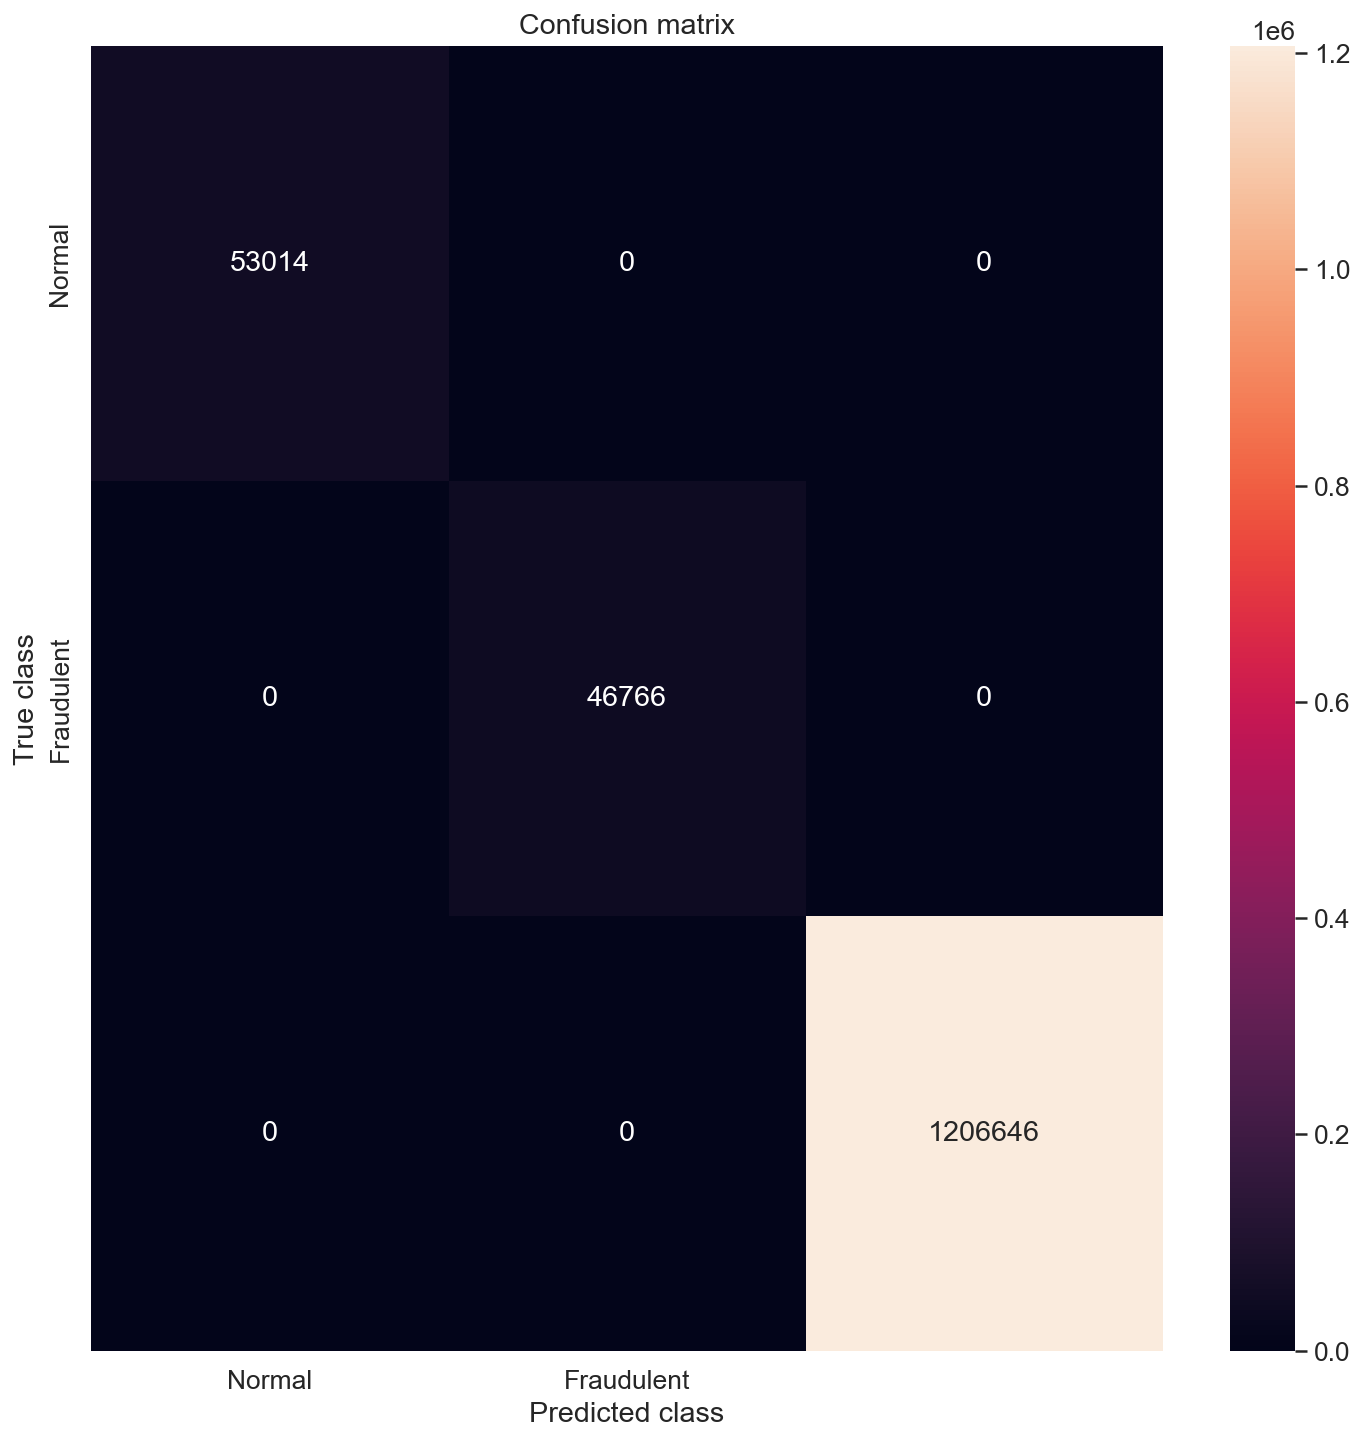

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53014
           1       1.00      1.00      1.00     46766
           2       1.00      1.00      1.00   1206646

    accuracy                           1.00   1306426
   macro avg       1.00      1.00      1.00   1306426
weighted avg       1.00      1.00      1.00   1306426



In [22]:
from imblearn.under_sampling import RandomUnderSampler  

under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(X, y)

print ("Distribution before resampling {}".format(Counter(y)))
print ("Distribution after resampling {}".format(Counter(y_res)))
    
model = run_model(X_res, X, y_res, y)
pred_y = model.predict(X)
mostrar_resultados(y, pred_y)

In [23]:
X_res

,overall,vote,review_length,verified,Audio CD,MP3 Music,Vinyl
0,1,0,129,1,1.0,0.0,0.0
1,1,0,219,1,1.0,0.0,0.0
2,1,0,34,0,0.0,1.0,0.0
3,1,2,79,1,1.0,0.0,0.0
4,1,0,74,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...
140293,4,0,126,1,0.0,1.0,0.0
140294,5,0,349,0,1.0,0.0,0.0
140295,5,0,61,1,0.0,1.0,0.0
140296,4,0,57,1,0.0,1.0,0.0


In [24]:
y_res

0         0
1         0
2         0
3         0
4         0
         ..
140293    2
140294    2
140295    2
140296    2
140297    2
Name: sentiment, Length: 140298, dtype: int64

In [25]:
df_newest = pd.concat([X_res, y_res], axis=1)

In [26]:
df_newest

,overall,vote,review_length,verified,Audio CD,MP3 Music,Vinyl,sentiment
0,1,0,129,1,1.0,0.0,0.0,0
1,1,0,219,1,1.0,0.0,0.0,0
2,1,0,34,0,0.0,1.0,0.0,0
3,1,2,79,1,1.0,0.0,0.0,0
4,1,0,74,1,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
140293,4,0,126,1,0.0,1.0,0.0,2
140294,5,0,349,0,1.0,0.0,0.0,2
140295,5,0,61,1,0.0,1.0,0.0,2
140296,4,0,57,1,0.0,1.0,0.0,2


In [27]:
##SI VA HACER EL ANALISIS BIVARIADO AGREGUE ESTE FILTRO. DE RESTO DEJELO COMENTADO
#df = df[df['reviewTime'] >= '01-01-2016']

AxesSubplot(0.260833,0.125;0.503333x0.755)


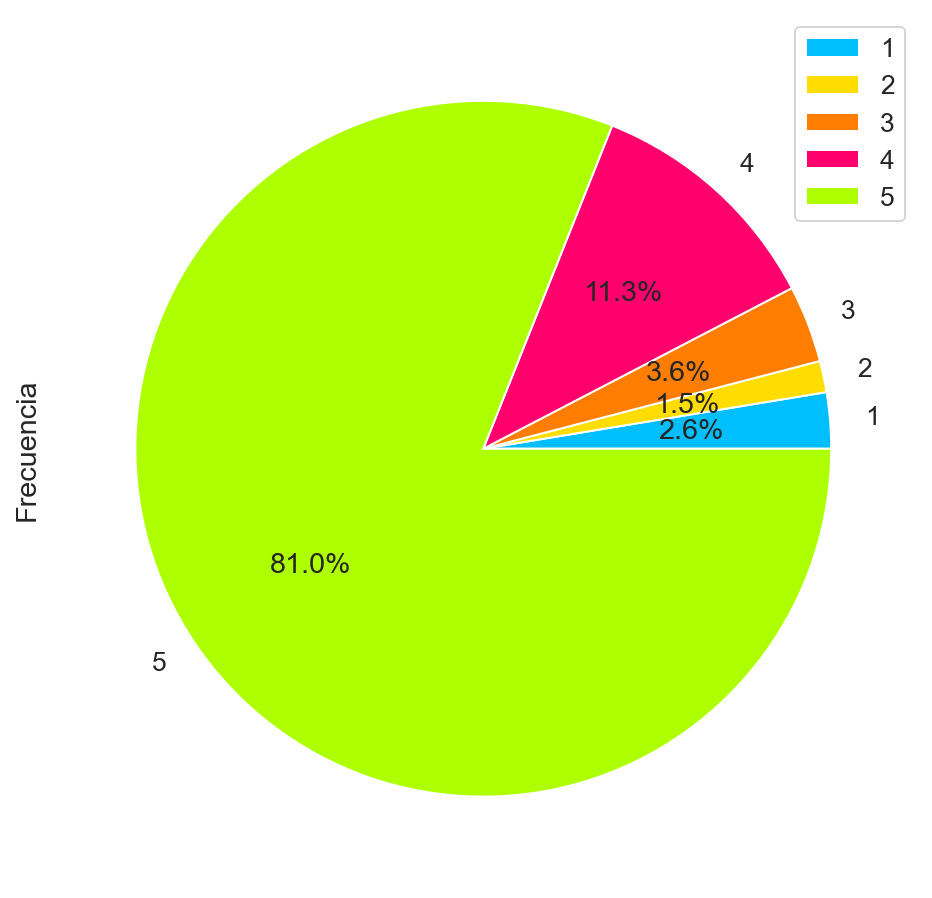

In [28]:
###ANALISIS UNIVARIADO
#Pie Chart, porcentajes de OverAll 
df_overall = df[['reviewerID', 'overall']]
pie_overall = df_overall.groupby('overall').agg('count')
pie_overall = pie_overall.rename(columns={'reviewerID': 'Frecuencia'})
pie_overall

axis = pie_overall.plot.pie(y='Frecuencia', autopct="%.1f%%", rot=0)
print(axis)
plt.show()


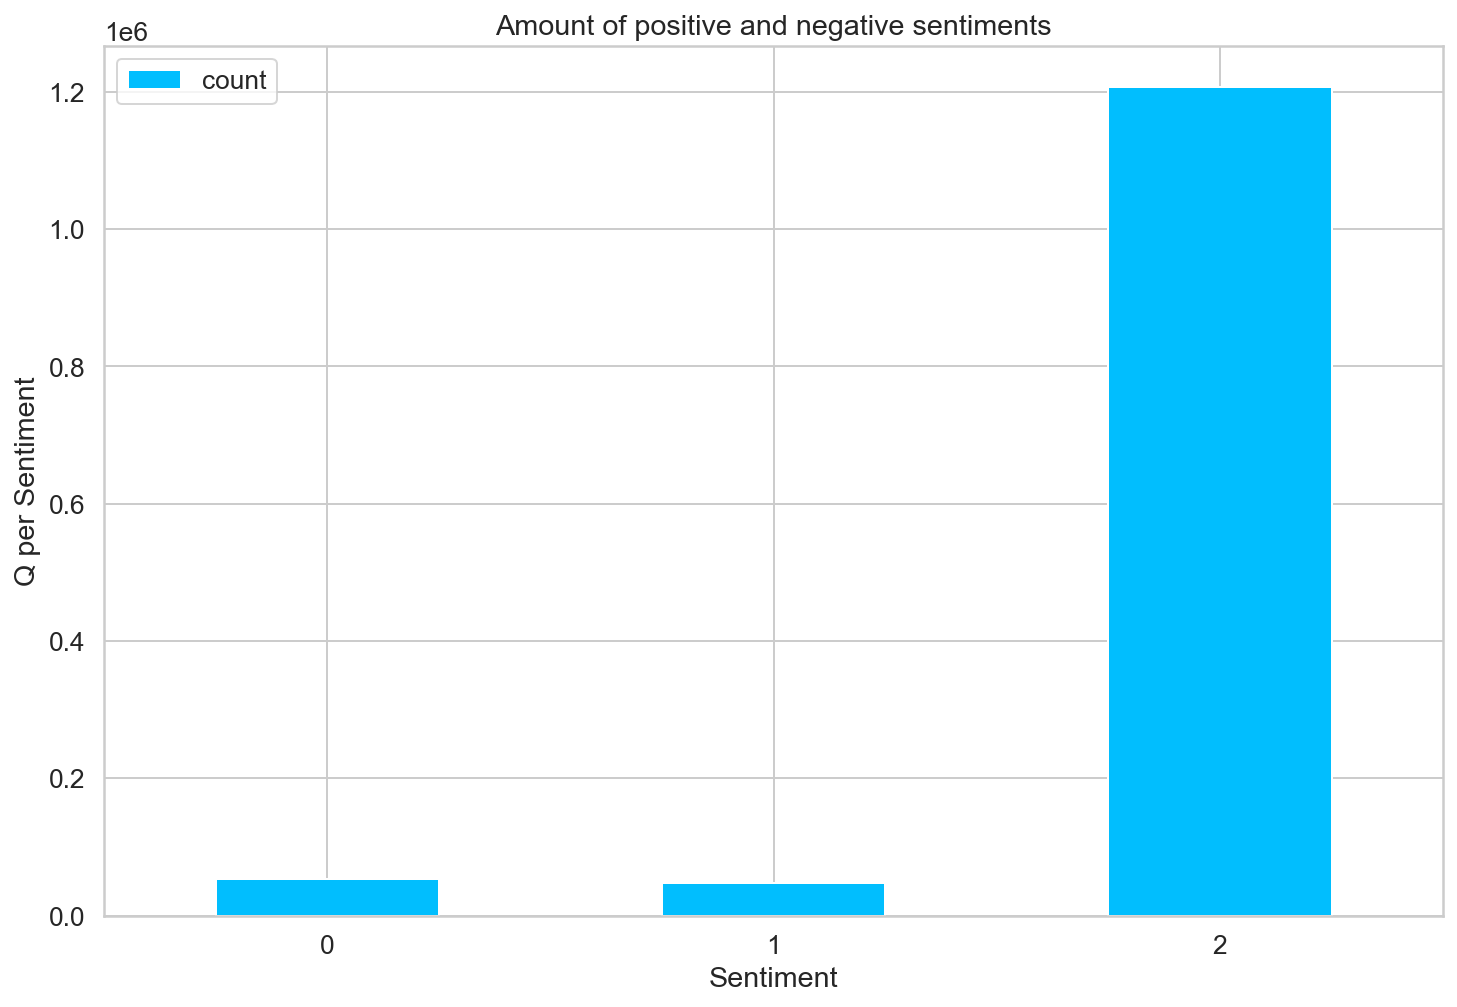

In [29]:
#Cantidad de sentimientos positivos y negativos
dfbp = pd.DataFrame({'count': df.groupby([ 'sentiment']).size()})
dfbp.head(5)

grafico = dfbp.plot.bar(y='count', rot=0)
plt.title("Amount of positive and negative sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Q per Sentiment")

plt.show()

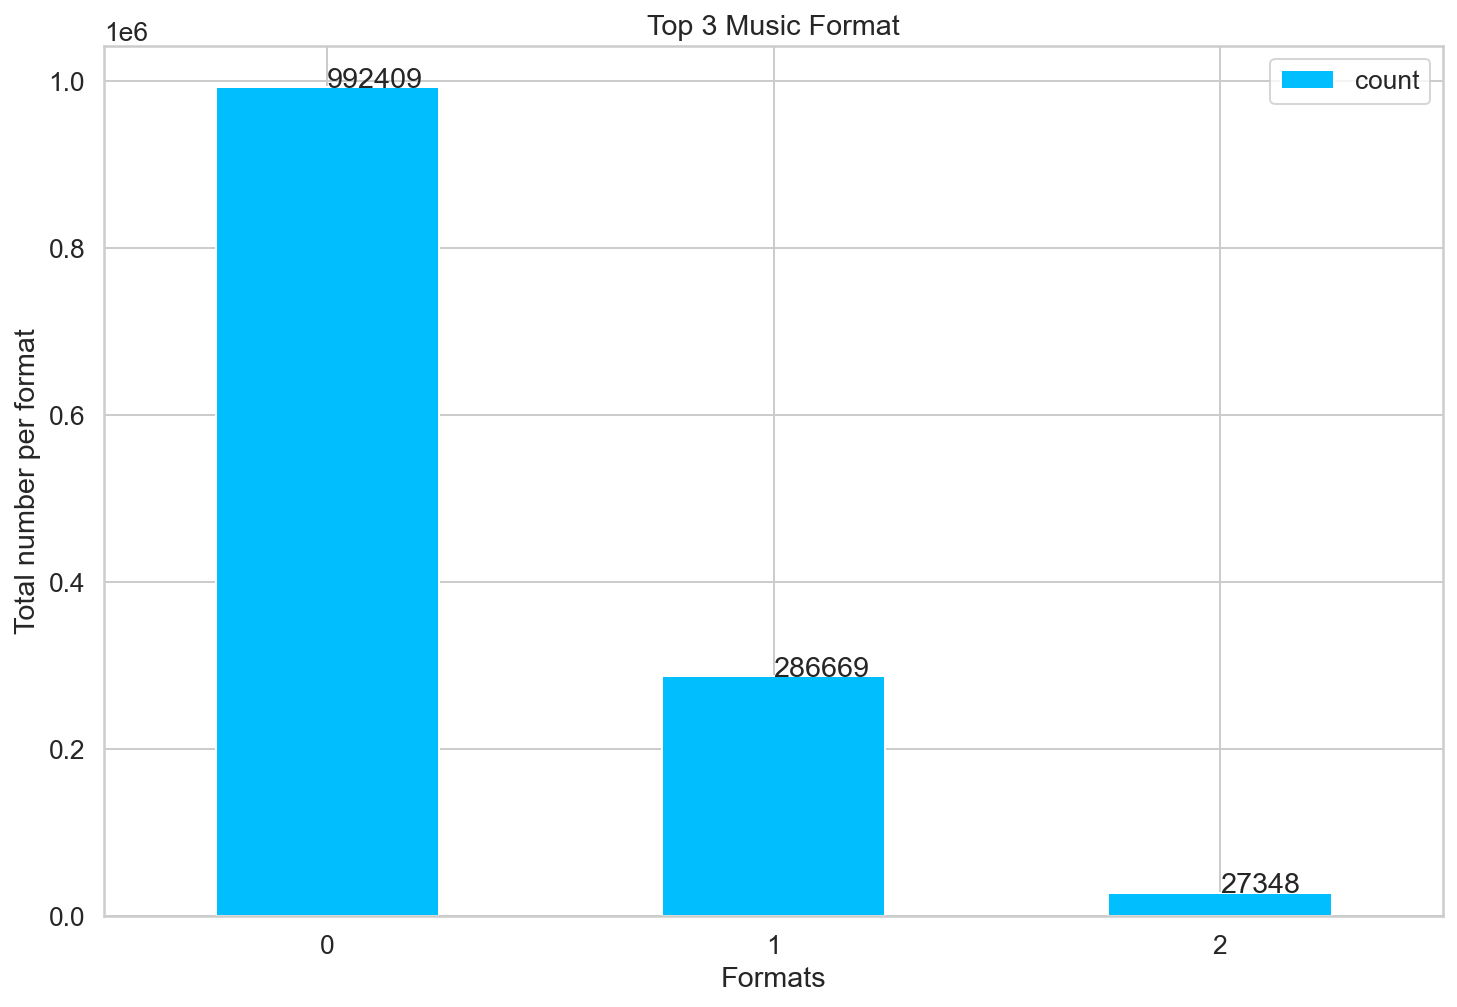

In [30]:
#Baplot para identificar el top 3 de Format 
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

dfformat = pd.DataFrame({'count': df.groupby(['style.Format:']).size()})
dflargest = dfformat.nlargest(3, 'count')

dflargest = dflargest.reset_index()

axis = dflargest.plot.bar(y='count', rot=0)
plt.title("Top 3 Music Format")
plt.xlabel("Formats")
plt.ylabel("Total number per format")
addlabels(dflargest['style.Format:'], dflargest['count'])
plt.show()

In [31]:
###ANALISIS BIVARIADO
##Recuerde descomentar este apartado despues de agregar el filtro de fecha para que se puedan procesar bien los datos.
#prof = pandas_profiling.ProfileReport(df)
#prof

In [32]:
#### Agrupación sentiment vs overall para análisis númerico con categórico
df_s_o=df.groupby('sentiment')['overall'].mean()
###Creación de tabla para comparar dos variables categóricas (overall y sentiment)
df_s_o=pd.crosstab(df['overall'],df['sentiment'])
value=df_s_o.values
print(chi2_contingency(value)[0:3])
df_s_o
# Se confirma que la división de sentimiento positivo(1) negativo (0) fue hecha de manera correcta, ya que se ve una media para el sentimiento negativo de 1.76 y para un sentimiento positivo de 4.8
#Hay dependencia entre la variable de sentimiento y el overall

(2612852.0, 0.0, 8)


sentiment,0,1,2
overall,,,
1,33993,0,0
2,19021,0,0
3,0,46766,0
4,0,0,147909
5,0,0,1058737


In [33]:
df_s_r=df.groupby('sentiment')['review_length'].mean()

df_s_r
#No existe ninguna relación significativa entre la cantidad de caracteres del comentario y el sentimiento generado 

sentiment
0    287.719319
1    343.283411
2    205.358461
Name: review_length, dtype: float64

In [34]:
###Creación de tabla para comparar dos variables categóricas (style.Format: y sentiment)
df_s_s=pd.crosstab(df['style.Format:'],df['sentiment'])
value=df_s_s.values
print(chi2_contingency(value)[0:3])

(8564.571249693161, 0.0, 4)


In [35]:
df_s_s

sentiment,0,1,2
style.Format:,,,
Audio CD,17197,15304,254168
MP3 Music,33796,30090,928523
Vinyl,2021,1372,23955


In [36]:
#Ho : si hay independencia entre sentimiento y el formato en el que viene la música
#Ha: si hay dependencia entre sentimiento y el formato en el que viene la música
#Como el P valor es menor al número de significancia entonces se rechaza la Ho, por lo cual si existe una dependencia entre el formato y el sentimiento, siento el top 3 el CD,MP3 y Vinyl.

In [37]:
###Creación de tabla para comparar dos variables categóricas (verified y sentiment)
df_v_s=pd.crosstab(df['verified'],df['sentiment'])
value=df_v_s.values
print(chi2_contingency(value)[0:3])
df_v_s

#Ho : si hay independencia entre sentimiento y el comentario verificado 
#Ha: si hay dependencia entre sentimiento y el comentario verificado 
#Como el P valor es menor al número de significancia entonces se rechaza la Ho, por lo cual si existe una dependencia entre el comentario verificado y el sentimiento


(6743.335590671487, 0.0, 2)


sentiment,0,1,2
verified,,,
False,19485,10995,260985
True,33529,35771,945661


In [38]:
df_s_v=df.groupby('overall')['vote'].mean()
df_s_v

#Los votos disminuyen a medida que el overall aumentan

overall
1    1.797252
2    1.321066
3    0.737544
4    0.516926
5    0.383246
Name: vote, dtype: float64

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [40]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [41]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\gabal\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [42]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [43]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [44]:
token_lens = []

for txt in df.reviewText:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

C:\Users\gabal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


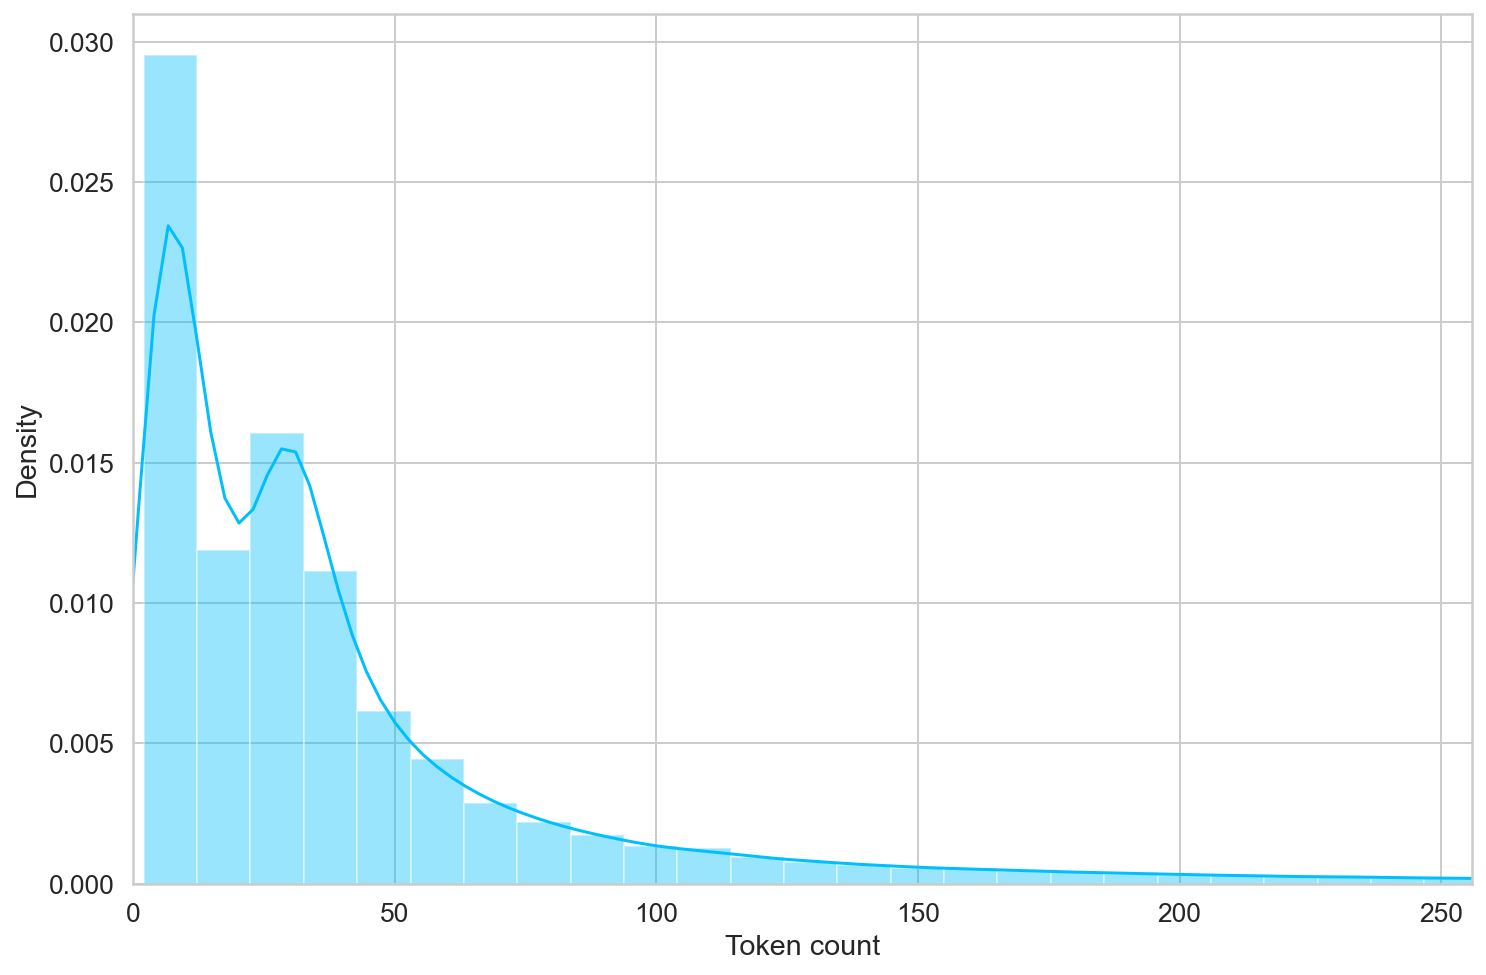

In [45]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [46]:
MAX_LEN = 150

In [47]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [48]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [49]:
df_train.shape, df_val.shape, df_test.shape

((1175783, 10), (65321, 10), (65322, 10))

In [50]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.reviewText.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [51]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
#AQUI ES DONDE SE QUEDA CARGANDO EL CODIGO, SEGURAMENTE POR LA CANTIDAD DE DATOS QUE TENEMOS.
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-cased')

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

In [ ]:
bert_model.config.hidden_size

In [ ]:
pooled_output.shape

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')